<a href="https://colab.research.google.com/github/ianxdxd/JobPostingAnalysis/blob/main/DataCleaning_JobPosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset Download

In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!pwd

/content


In [6]:
!kaggle datasets download -d rashikrahmanpritom/data-science-job-posting-on-glassdoor

Dataset URL: https://www.kaggle.com/datasets/rashikrahmanpritom/data-science-job-posting-on-glassdoor
License(s): CC0-1.0
  0% 0.00/1.53M [00:00<?, ?B/s]
100% 1.53M/1.53M [00:00<00:00, 73.5MB/s]


In [7]:
!unzip /content/data-science-job-posting-on-glassdoor.zip

Archive:  /content/data-science-job-posting-on-glassdoor.zip
  inflating: Cleaned_DS_Jobs.csv     
  inflating: Uncleaned_DS_jobs.csv   


## Data Cleaning and Preparation

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

In [82]:
df = pd.read_csv("Uncleaned_DS_jobs.csv")

In [ ]:
df.head()

In [ ]:
df.info()
"""
No need for df.isnull().sum(), as we can see there aren't any missing values in
any column of the dataset. As a matter of fact, there are, they are represented by -1
"""

In [ ]:
df.duplicated().sum()

In [ ]:
df.describe()

In [83]:
df = df.drop(labels=["index", "Competitors", "Job Description"], axis=1)
# Dropping the Job Description field as it might not provide valuable information without analyzing the context as a whole.

In [ ]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

In [ ]:
for col in df.columns:
    print(f"{col}: {df[col].value_counts()} \n")

### Format Categorical Columns

In [84]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    if df[col].str.contains("\n", na=False).any():
        df[col] = df[col].str.replace("\n", " ", regex=False)

In [85]:
df["Salary Estimate"] = (df["Salary Estimate"]
                         .str.replace("(Glassdoor est.)", "", regex=False)
                         .str.replace("$", "", regex=False)
                         .str.replace("K", "", regex=False)
                         .str.replace("(Employer est.)", "", regex=False))

df["Company Name"] = (df["Company Name"].apply(lambda x: ' '.join([word for word in x.split() if not word.replace('.', '', 1).isdigit()])))

df["Size"] = (df["Size"]
              .str.replace(" to ", "-", regex=False)
              .str.replace("employees", "", regex=False))

df["Revenue"] = (df["Revenue"]
                 .str.replace(" to ", "-", regex=False)
                 .str.replace("(USD)", "", regex=False)
                 .str.replace("$", "", regex=False))

### Handling Missing Values

In [86]:
df_cleaned = df.drop(labels=["Salary Estimate", "Size"], axis = 1)
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    df[col] = df[col].replace("-1", "NA")

df["Revenue"] = df["Revenue"].str.replace("Unknown / Non-Applicable", "NA", regex=False)
df["Size"] = df["Size"].str.replace("Unknown", "-1", regex=False)

### Creating New Features

In [87]:
df["min_salary"] = df["Salary Estimate"].apply(lambda x: float(x.split("-")[0]))
df["max_salary"] = df["Salary Estimate"].apply(lambda x: float(x.split("-")[1]))
df["avg_salary"] = df["Salary Estimate"].apply(lambda x: (float(x.split("-")[0]) + float(x.split("-")[1]))/2)
df["job_state"] = df["Location"].apply(
    lambda x: x.split(", ")[1] if isinstance(x, str) and ", " in x else "NA"
)

keywords = [
    "Vice President|VP",
    "Researcher",
    "Principal",
    "Senior|Sr",
    "Manager",
    "Specialist",
    "Junior|Jr"
]

for keyword in keywords:
    column_name = keyword.split("|")[0] if "|" in keyword else keyword
    df[column_name] = df["Job Title"].str.contains(keyword, case=True, na=False).astype(int)

keyword_columns = [keyword.split("|")[0] if "|" in keyword else keyword for keyword in keywords]
df["Mid Level"] = (df[keyword_columns].sum(axis=1) == 0).astype(int)

def categorize_size(size):
    if isinstance(size, str):
        if size == "-1":
            return "Unknown"
        elif "10000+" in size:
            return "Large"
        else:
            try:
                if '-' in size:
                    lower, upper = map(int, size.split('-'))
                    if upper <= 50:
                        return "Small"
                    elif 51 <= lower <= 5000:
                        return "Medium"
                    elif upper > 5000:
                        return "Large"
                else:
                    return "Unknown"
            except ValueError:
                return "Unknown"
    return "Unknown"

df["Size Category"] = df["Size"].apply(categorize_size)

In [88]:
df.head()

,Job Title,Salary Estimate,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,...,job_state,Vice President,Researcher,Principal,Senior,Manager,Specialist,Junior,Mid Level,Size Category
0,Sr Data Scientist,137-171,3.1,Healthfirst,"New York, NY","New York, NY",1001-5000,1993,Nonprofit Organization,Insurance Carriers,...,NY,0,0,0,1,0,0,0,0,Medium
1,Data Scientist,137-171,4.2,ManTech,"Chantilly, VA","Herndon, VA",5001-10000,1968,Company - Public,Research & Development,...,VA,0,0,0,0,0,0,0,1,Large
2,Data Scientist,137-171,3.8,Analysis Group,"Boston, MA","Boston, MA",1001-5000,1981,Private Practice / Firm,Consulting,...,MA,0,0,0,0,0,0,0,1,Medium
3,Data Scientist,137-171,3.5,INFICON,"Newton, MA","Bad Ragaz, Switzerland",501-1000,2000,Company - Public,Electrical & Electronic Manufacturing,...,MA,0,0,0,0,0,0,0,1,Medium
4,Data Scientist,137-171,2.9,Affinity Solutions,"New York, NY","New York, NY",51-200,1998,Company - Private,Advertising & Marketing,...,NY,0,0,0,0,0,0,0,1,Medium


## Analysis

#### What is the correlation between State and the amount of Job Titles?

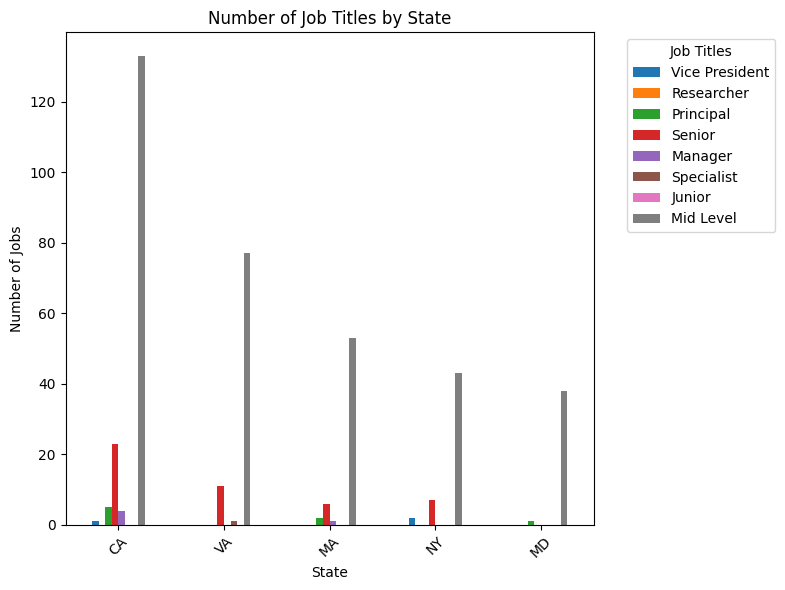

In [19]:
keywords = [
    "Vice President", "Researcher", "Principal",
    "Senior", "Manager", "Specialist", "Junior", "Mid Level",
]

state_top5 = df["job_state"].value_counts().head(5).index.tolist()

filtered_df = df[df["job_state"].isin(state_top5)]

job_counts = pd.DataFrame(index=state_top5, columns=keywords)

for state in state_top5:
    state_df = filtered_df[filtered_df["job_state"] == state]
    for title in keywords:
        job_counts.loc[state, title] = state_df[title].sum()

job_counts.plot(kind='bar', figsize=(8, 6))

plt.title('Number of Job Titles by State')
plt.xlabel('State')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=45)
plt.legend(title="Job Titles", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

As we can observe, California dominates in terms of job availability within this dataset. This is likely due to the high concentration of tech companies in the state.

Additionally, the majority of job titles appear to be mid-level positions. This classification was made by identifying the most frequent keywords in the "Job Titles" column, and any job titles that did not match these keywords were categorized as "Mid Level."

Finally, there were only three "Vice President" positions in the dataset, and they were primarily located in major citites in New York and California. This suggests that the positions might be concentrated in these areas due to the presence of corporate headquarters in these large metropolitan centers. However, this is a point that could be further explored and analyzed.

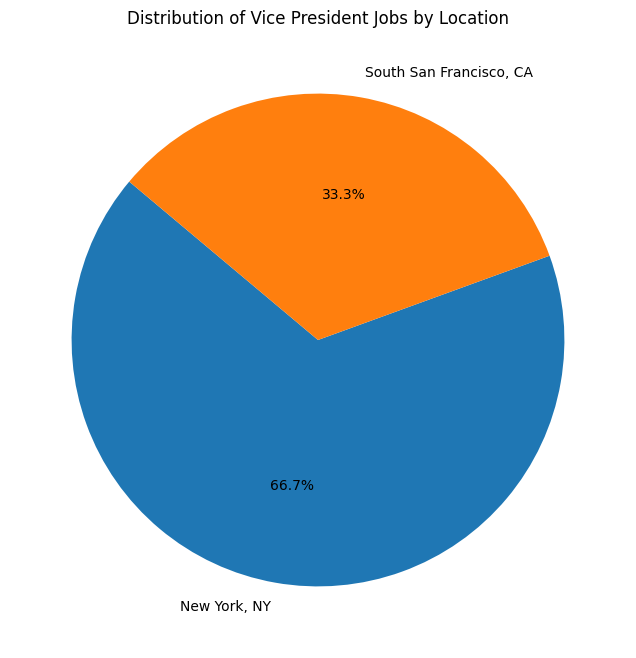

In [20]:
vp_rows = df[df["Vice President"] == 1]
location_counts = vp_rows["Headquarters"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    location_counts,
    labels=location_counts.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Distribution of Vice President Jobs by Location')
plt.show()

Building on the hypothesis that Vice President job opportunities are concentrated in states where company headquarters are located, we analyzed the distribution of these positions across different locations.

Typically, Vice Presidents work in close proximity to CEOs, often at the company's headquarters. The pie chart supports this observation, showing that these roles are predominantly found in states known for hosting corporate headquarters, such as New York and California. This reinforces the idea that these states serve as key hubs for executive-level positions

#### Company and Total number of Job Listings

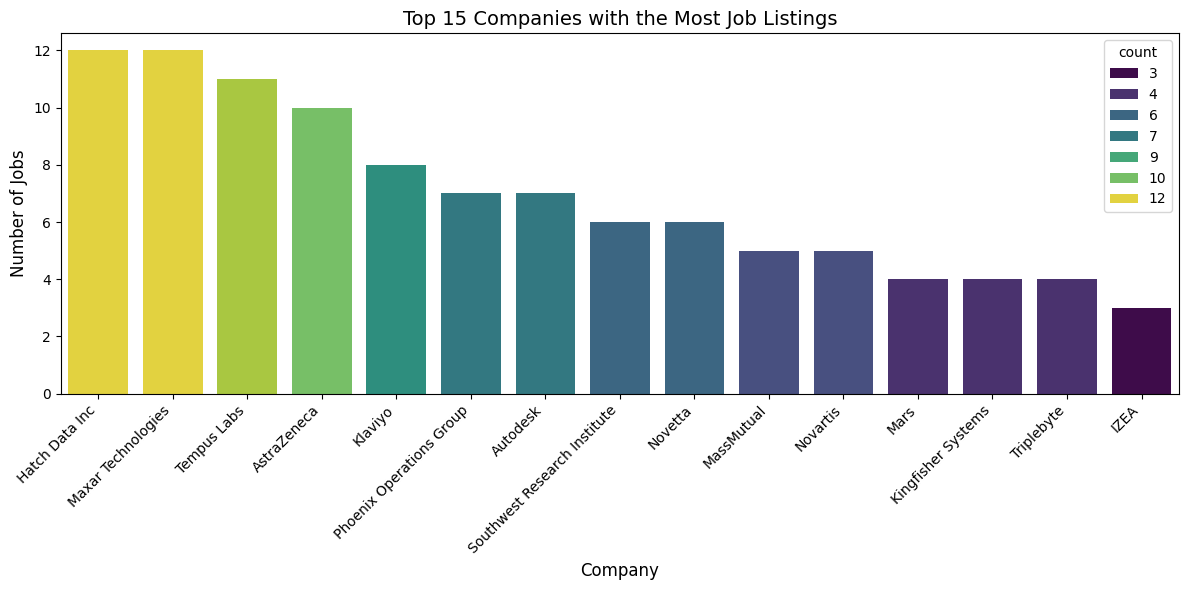

In [21]:
top_15_companies = df["Company Name"].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_15_companies.index,
    y=top_15_companies.values,
    palette="viridis", hue=top_15_companies
)

plt.title('Top 15 Companies with the Most Job Listings', fontsize=14)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Looking at the graph below, the main objective was to identify the top 15 companies with the highest number of job listings and highlight some of the major players in the market. To extract more valuable insights and investigate whether revenue correlates with the number of job listings a company has, we’ll need to analyze additional graphs and metrics.

It’s important to note that job listings often do not follow a predictable pattern, as companies typically post positions to fill specific vacancies within their organizations. Furthermore, revenue alone may not be the best indicator for this analysis. A more suitable metric would be the company's income (Revenue - Expenses), as it provides a clearer picture of financial health and its potential relationship with hiring trends.

#### Is there a correlation between Company Job Listings and Revenue?

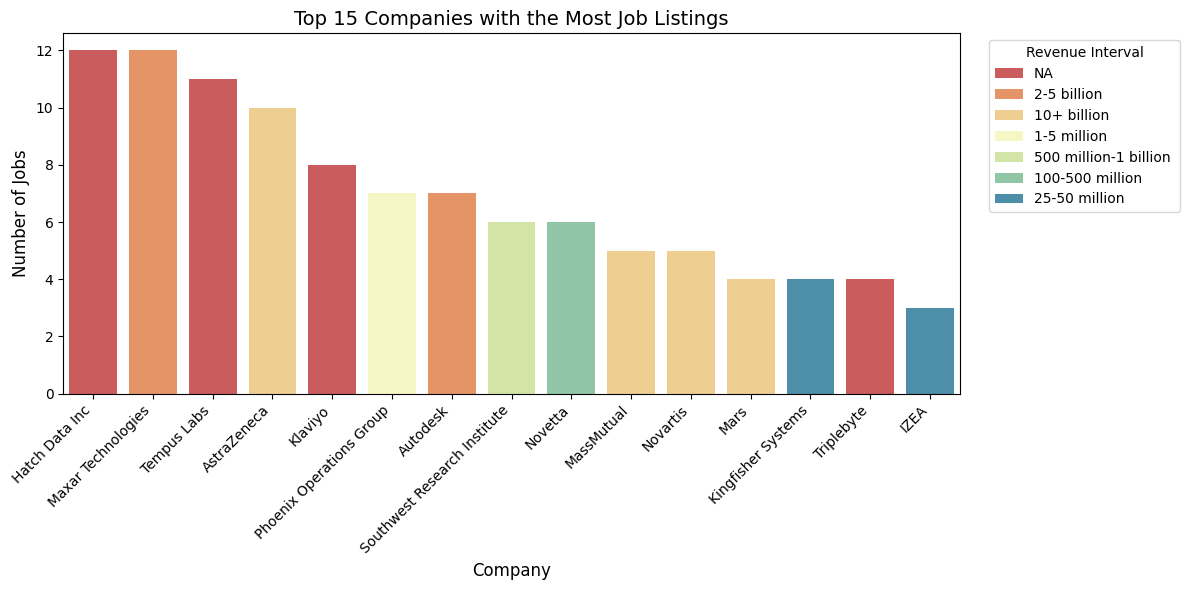

In [37]:
top_15_companies = df["Company Name"].value_counts().head(15)
top_15_revenue = df.groupby("Company Name")["Revenue"].first().loc[top_15_companies.index]
top_15_df = pd.DataFrame({
    "Company Name": top_15_companies.index,
    "Job Listings": top_15_companies.values,
    "Revenue": top_15_revenue
})

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Company Name",
    y="Job Listings",
    hue="Revenue",
    data=top_15_df,
    palette="Spectral"
)

plt.title('Top 15 Companies with the Most Job Listings', fontsize=14)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Revenue Interval", bbox_to_anchor=(1.025, 1), loc='upper left')

plt.tight_layout()
plt.show()

After analyzing the graph, we cannot conclude that revenue alone is directly associated with the number of job listings a company has. Interestingly, approximately 3 out of the 5 companies with the highest number of job listings did not have their revenue data available.

The breakdown of the numbers reveals the following:

* 26.7% of companies did not have revenue data available.
* 26.7% reported a revenue of more than 10 billion dollars.
* 13.3% had a revenue of approximately 2 to 5 billion dollars.
* 13.3% reported a revenue of about 25 to 50 million dollars.
* 6.7% had a revenue of approximately 1 to 5 million dollars.
* 6.7% reported a revenue of about 100 to 500 million dollars.
* 6.7% had a revenue in the range of 500 million to 1 billion dollars.

These findings suggest that job listings are not necessarily tied to a company's revenue. Additional factors may play a more significant role in determining the number of job vacancies.

#### Searching for correlation in Company Salary Range and Amount of Jobs

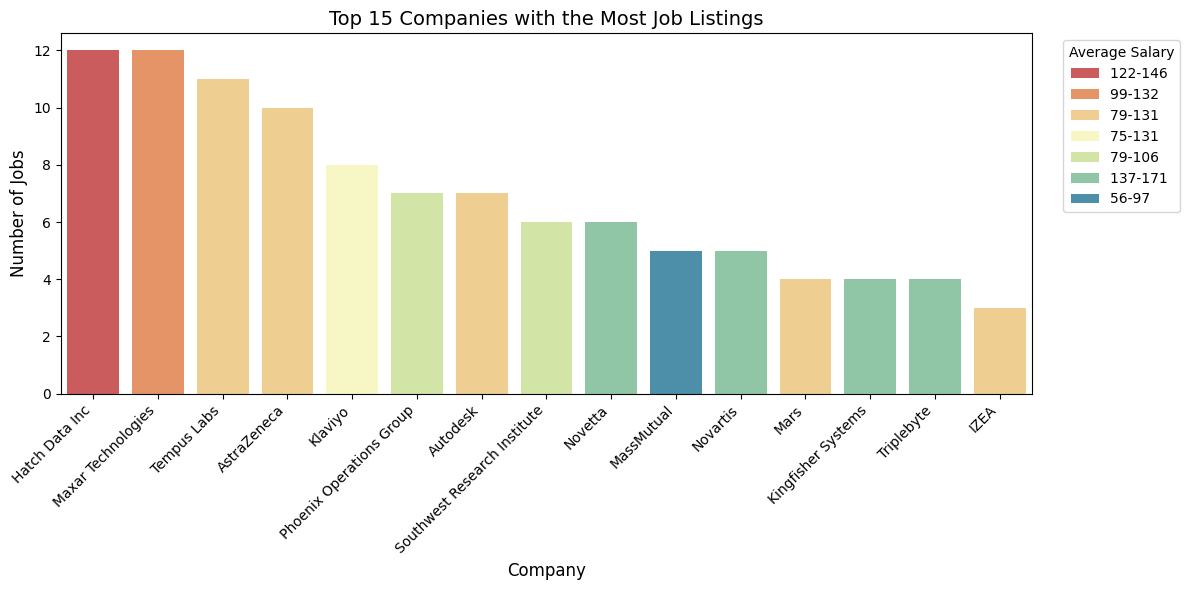

In [41]:
top_15_companies = df["Company Name"].value_counts().head(15)
top_15_Salary = df.groupby("Company Name")["Salary Estimate"].first().loc[top_15_companies.index]
top_15_df = pd.DataFrame({
    "Company Name": top_15_companies.index,
    "Job Listings": top_15_companies.values,
    "Salary": top_15_Salary
})

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Company Name",
    y="Job Listings",
    hue="Salary",
    data=top_15_df,
    palette="Spectral"
)

plt.title('Top 15 Companies with the Most Job Listings', fontsize=14)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Average Salary", bbox_to_anchor=(1.025, 1), loc='upper left')

plt.tight_layout()
plt.show()

There appears to be little to no correlation between a company's revenue and its salary range. Smaller companies, such as Kingfisher Systems, often offer better salary ranges compared to larger revenue-generating companies. As previously mentioned, additional factors—such as industry demand, specific skill requirements, and the business impact of a given role—play a much larger role in determining both the number of job vacancies and the salary range offered.



#### Does Company Size Influence in the Amount of Job Listings?

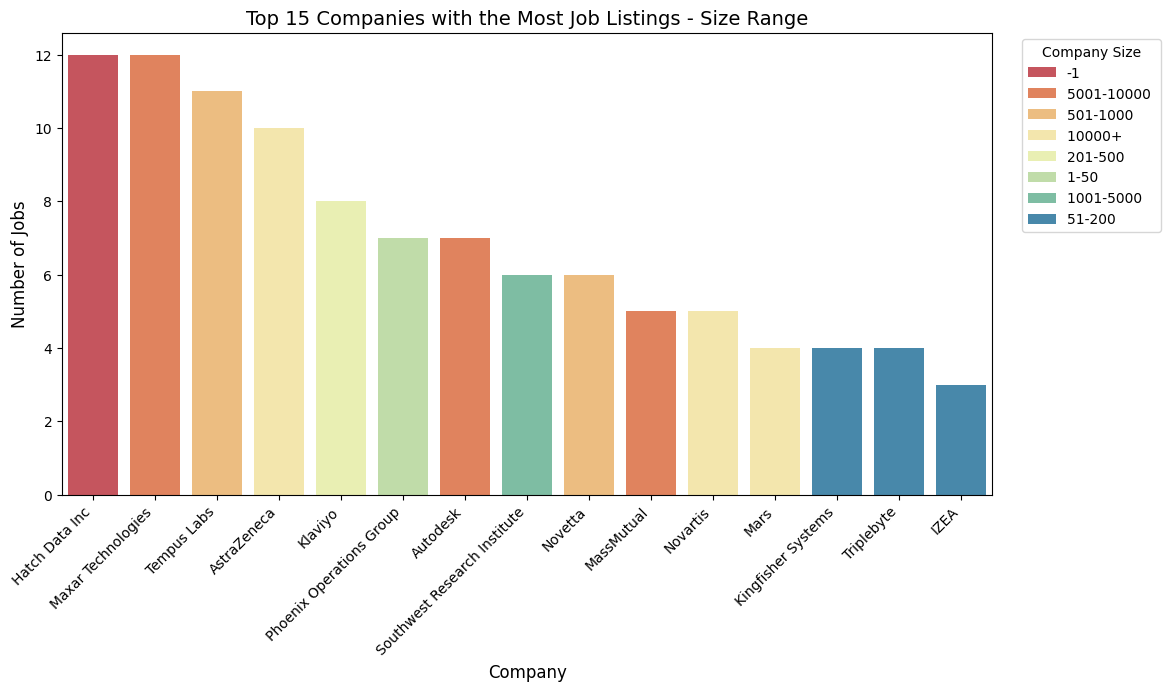

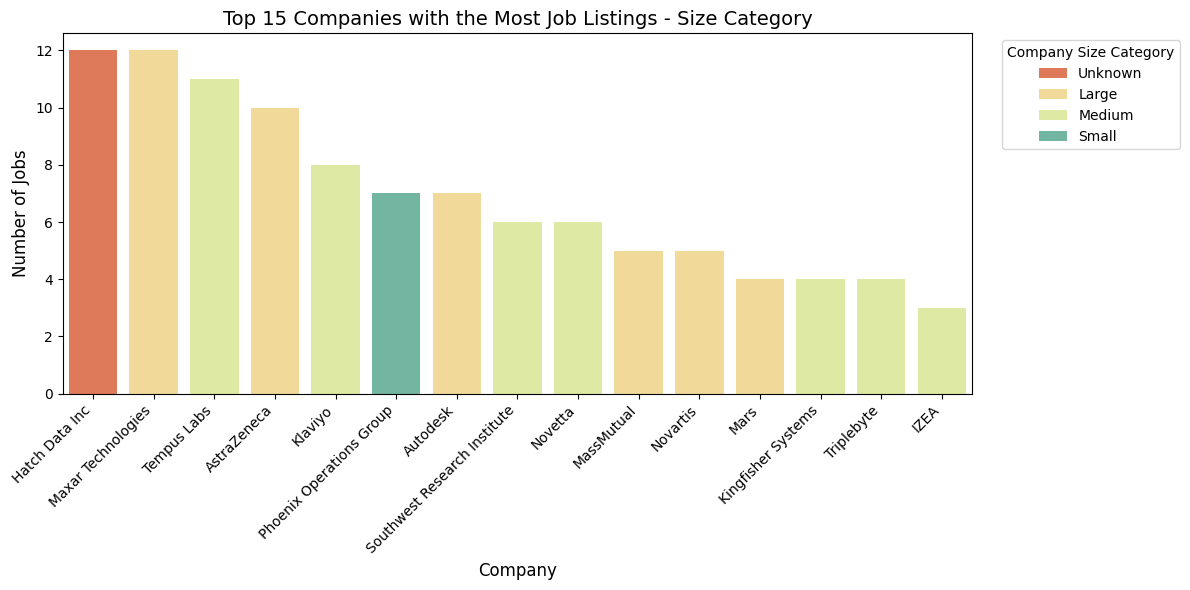

In [93]:
top_15_companies = df["Company Name"].value_counts().head(15)

top_15_Size = df.groupby("Company Name")["Size"].first().loc[top_15_companies.index]
top_15_df = pd.DataFrame({
    "Company Name": top_15_companies.index,
    "Job Listings": top_15_companies.values,
    "Size": top_15_Size
})

top_15_SizeCategory = df.groupby("Company Name")["Size Category"].first().loc[top_15_companies.index]
top_15_df_category = pd.DataFrame({
    "Company Name": top_15_companies.index,
    "Job Listings": top_15_companies.values,
    "Size": top_15_SizeCategory
})


plt.figure(figsize=(12, 6))
sns.barplot(
    x="Company Name",
    y="Job Listings",
    hue="Size",
    data=top_15_df,
    palette="Spectral"
)

plt.title("Top 15 Companies with the Most Job Listings - Size Range", fontsize=14)
plt.xlabel("Company", fontsize=12)
plt.ylabel("Number of Jobs", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Company Size", bbox_to_anchor=(1.025, 1), loc="upper left")

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Company Name",
    y="Job Listings",
    hue="Size",
    data=top_15_df_category,
    palette="Spectral"
)

plt.title("Top 15 Companies with the Most Job Listings - Size Category", fontsize=14)
plt.xlabel("Company", fontsize=12)
plt.ylabel("Number of Jobs", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Company Size Category", bbox_to_anchor=(1.025, 1), loc="upper left")

plt.tight_layout()
plt.show()

Based on the graph, like the other company size does not seem to play a big role in determining the amount of job listings. This suggests that while larger and medium size companies may have more job openings on average, company size alone does not dictate the number of job listings.

#### Does Company size affect the Average Salary?

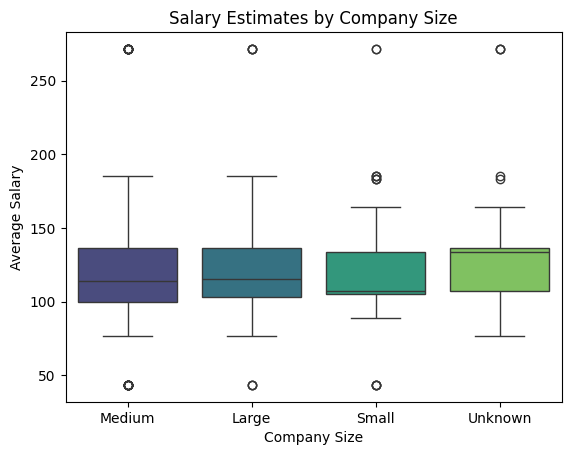

In [97]:
sns.boxplot(data=df,
            x="Size Category",
            y="avg_salary",
            palette="viridis",
            hue="Size Category")
plt.title("Salary Estimates by Company Size")
plt.xlabel("Company Size")
plt.ylabel("Average Salary")
plt.show()

The box plot suggests that Medium and Large companies tend to have slightly higher average salaries compared to Small and Unknown companies. However, the difference is not substantial, as their salary distributions overlap significantly. This indicates that company size may not be a major determining factor in salary levels.

#### What is the correlation between Average Salary, Industry Type and Job Listings?

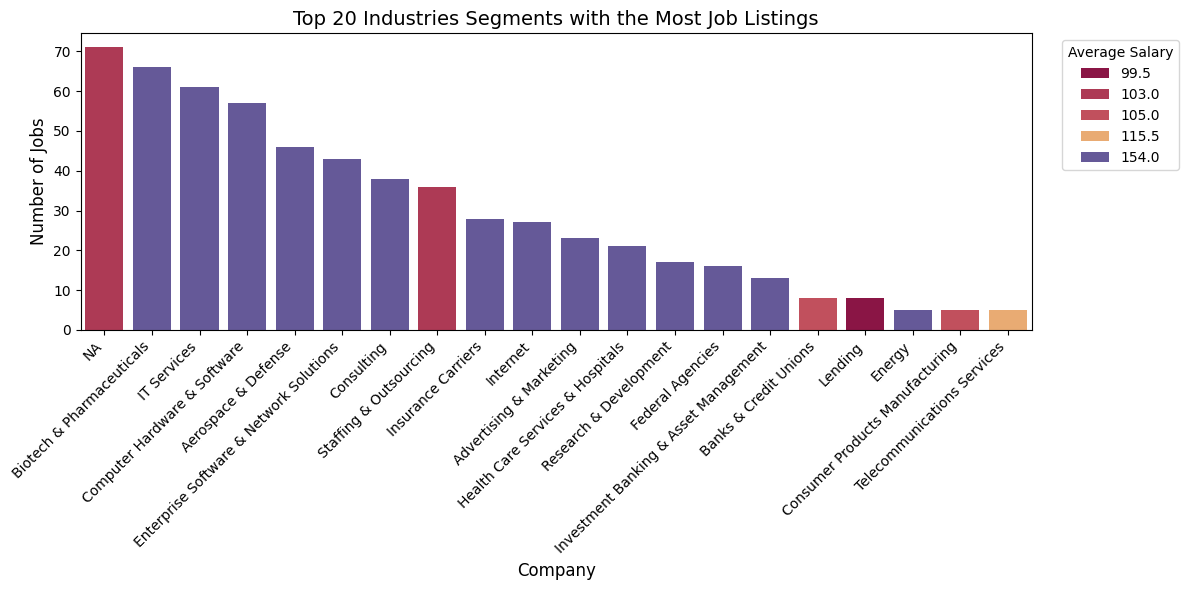

In [104]:
top_20_industries = df["Industry"].value_counts().head(20)
top_20_avg_salary = df.groupby("Industry")["avg_salary"].first().loc[top_20_industries.index]
top_20_df = pd.DataFrame({
    "Industry": top_20_industries.index,
    "Job Listings": top_20_industries.values,
    "Average Salary": top_20_avg_salary
})

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Industry",
    y="Job Listings",
    hue="Average Salary",
    data=top_20_df,
    palette="Spectral"
)

plt.title('Top 20 Industries Segments with the Most Job Listings', fontsize=14)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Average Salary", bbox_to_anchor=(1.025, 1), loc='upper left')

plt.tight_layout()
plt.show()

The bar plot indicates that higher salaries tend to be more prevalent in tech segments such as IT Services, Computer Hardware, Software, and similar industries. This trend is likely attributed to the rapid technological advancements and significant investments in these sectors over the past few years, which have driven up demand for skilled professionals and, consequently, salary levels.

#### Does Geographic Location Impact on the Average Salary?

In [110]:
fig = px.choropleth(locations=df["job_state"], locationmode="USA-states", color=df["avg_salary"], scope="usa")
fig.show()

The map suggests a correlation between geographic location and average salary. States with a higher cost of living, such as California (CA) and New York (NY), tend to have higher salaries. However, some states with a lower cost of living also show relatively high salaries, indicating that factors beyond cost of living may also influence wage levels.